# Fraudulent Provider Dataset Construction (PART 2)
## STEP 1
* Process DOJ Press Release Text to Extract Relevant Data Elements

## STEP 2
* Perform NPPES NPI Lookup (via API) for All Potential Provider Names

In [1]:
# Import Pyhon libraries
import os
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import re
import requests
import json
from easydict import EasyDict as edict

nlp = spacy.load("en_core_web_sm")   # prepare for NLP with SpaCy

In [2]:
# Load State Abbreviations 
df_state_abbrev = pd.read_csv('state_abbrev.csv')
df_state_abbrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   state      52 non-null     object 
 1   latitude   52 non-null     float64
 2   longitude  52 non-null     float64
 3   name       52 non-null     object 
dtypes: float64(2), object(2)
memory usage: 1.8+ KB


In [3]:
df_state_abbrev.sample(5)

,state,latitude,longitude,name
10,GA,32.157435,-82.907123,Georgia
13,ID,44.068202,-114.742041,Idaho
41,SC,33.836081,-81.163725,South Carolina
20,MD,39.045755,-76.641271,Maryland
33,NV,38.802610,-116.419389,Nevada


In [7]:
# Load DOJ Press Releases scraped from website
df_press_releases = pd.read_csv('DOJ_Press_Releases.csv')
df_press_releases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   release_date    132 non-null    object
 1   release_agency  132 non-null    object
 2   release_title   132 non-null    object
 3   release_url     132 non-null    object
 4   release_text    120 non-null    object
dtypes: object(5)
memory usage: 5.3+ KB


In [8]:
# Display Press Releases which were empty when scraped
df_error_rows = pd.DataFrame()
df_error_rows = df_press_releases[(df_press_releases['release_text'].isna() == True)].copy()
df_error_rows

,release_date,release_agency,release_title,release_url,release_text
74,2017-07-21T00:00:00-04:00,Office of Public Affairs,Barrio Azteca Gang Lieutenant Sentenced to Lif...,https://www.justice.gov/opa/pr/barrio-azteca-g...,NaN
76,2017-08-17T00:00:00-04:00,Office of Public Affairs,Justice Department Announces Actions to Streng...,https://www.justice.gov/opa/pr/justice-departm...,NaN
79,2017-09-20T00:00:00-04:00,Office of Public Affairs,Miami Physician Sentenced to 97 Months for Rol...,https://www.justice.gov/opa/pr/miami-physician...,NaN
86,2017-10-23T00:00:00-04:00,Office of Public Affairs,"30 Members and Associates of The ""Nine Trey Ga...",https://www.justice.gov/opa/pr/30-members-and-...,NaN
88,2017-10-25T00:00:00-04:00,Office of Public Affairs,Opening Statement by U.S. Attorney R. Trent Sh...,https://www.justice.gov/opa/pr/opening-stateme...,NaN
89,2017-10-26T00:00:00-04:00,Office of Public Affairs,Pittsburgh-Area Doctor Charged With Unlawfully...,https://www.justice.gov/opa/pr/pittsburgh-area...,NaN
90,2017-10-26T00:00:00-04:00,Office of Public Affairs,Founder and Owner of Pharmaceutical Company In...,https://www.justice.gov/opa/pr/founder-and-own...,NaN
91,2017-10-27T00:00:00-04:00,Office of Public Affairs,DEA Joins Local Law Enforcement Partners in Na...,https://www.justice.gov/opa/pr/dea-joins-local...,NaN
93,2017-11-07T00:00:00-05:00,Office of Public Affairs,Drug Enforcement Administration Collects Recor...,https://www.justice.gov/opa/pr/drug-enforcemen...,NaN
101,2017-01-13T00:00:00-05:00,Office of Public Affairs,Barrio Azteca Gang Lieutenant Pleads Guilty to...,https://www.justice.gov/opa/pr/barrio-azteca-g...,NaN


In [9]:
# Remove rows where Press Release text was no properly scraped from website
df_press_releases.dropna(subset=['release_text'], inplace=True)
df_press_releases

,release_date,release_agency,release_title,release_url,release_text
0,2020-03-10T00:00:00-04:00,Office of Public Affairs,Owner of Detroit-Area Health Care Clinic Sente...,https://www.justice.gov/opa/pr/owner-detroit-a...,The owner of a Detroit-area physical therapy c...
1,2019-10-29T00:00:00-04:00,Office of Public Affairs,Tennessee Medical Doctor and Advanced Practice...,https://www.justice.gov/opa/pr/tennessee-medic...,A Tennessee medical doctor and an advanced pra...
2,2019-11-13T00:00:00-05:00,Office of Public Affairs,Owner of Detroit-Area Health Care Clinics Plea...,https://www.justice.gov/opa/pr/owner-detroit-a...,"The owner of a Detroit, Michigan-area physical..."
3,2019-09-26T00:00:00-04:00,Office of Public Affairs,Federal Health Care Fraud Takedown in Northeas...,https://www.justice.gov/opa/pr/federal-health-...,The Justice Department today announced a coord...
4,2019-10-18T00:00:00-04:00,Office of Public Affairs,Two East Tennessee Doctors Plead Guilty to Opi...,https://www.justice.gov/opa/pr/two-east-tennes...,Two Tennessee doctors each pleaded guilty yest...
...,...,...,...,...,...
127,2015-05-14T00:00:00-04:00,Office of Public Affairs,Long-Term Care Pharmacy to Pay $31.5 Million t...,https://www.justice.gov/opa/pr/long-term-care-...,PharMerica Corporation has agreed to pay the U...
128,2013-08-09T00:00:00-04:00,Office of Public Affairs,United States Files Lawsuit Against PharMerica...,https://www.justice.gov/opa/pr/united-states-f...,The United States has filed suit against PharM...
129,2015-09-04T00:00:00-04:00,Office of Public Affairs,Versailles Man Indicted for Illegal Distributi...,https://www.justice.gov/opa/pr/versailles-man-...,A federal grand jury returned an indictment ch...
130,2015-07-28T00:00:00-04:00,Office of Public Affairs,Colombian National Charged in North Dakota wit...,https://www.justice.gov/opa/pr/colombian-natio...,Acting U.S. Attorney Christopher C. Myers for ...


In [10]:
df_press_releases.sample(5)

,release_date,release_agency,release_title,release_url,release_text
54,2018-04-03T00:00:00-04:00,Office of Public Affairs,Attorney General Jeff Sessions Announces Resul...,https://www.justice.gov/opa/pr/attorney-genera...,"Today, the Department of Justice, FBI and U.S...."
8,2019-11-25T00:00:00-05:00,Office of Public Affairs,Tennessee Emergency Medical Doctor Pleads Guil...,https://www.justice.gov/opa/pr/tennessee-emerg...,A Tennessee emergency medical doctor pleaded g...
68,2018-08-22T00:00:00-04:00,Office of Public Affairs,Operation Darkness Falls Results in Arrest of ...,https://www.justice.gov/opa/pr/operation-darkn...,"Today, the Department of Justice, U.S. Immigra..."
63,2018-06-29T00:00:00-04:00,Office of Public Affairs,South Florida Doctor Convicted Of Participatin...,https://www.justice.gov/opa/pr/south-florida-d...,"Dr. Andres Mencia, 64, of Fort Lauderdale, Flo..."
72,2018-08-28T00:00:00-04:00,Office of Public Affairs,Co-Owners of Miami Pain Management Clinic Plea...,https://www.justice.gov/opa/pr/co-owners-miami...,The husband and wife co-owners of a Miami pain...


In [47]:
# Create dataframe to contain monthly counts by year
df_pr_count = df_press_releases[[
    'release_date',
    'release_title'
]]

df_pr_count.sample(5)

,release_date,release_title
30,2018-10-25T00:00:00-04:00,Justice Department’s Criminal Division Creates...
31,2018-11-07T00:00:00-05:00,Co-Owners of Miami Pain Management Clinic and ...
43,2019-09-11T00:00:00-04:00,DEA Proposes to Reduce the Amount of Five Opio...
28,2018-10-25T00:00:00-04:00,Justice Department Announces $35 Million to Ba...
109,2017-01-26T00:00:00-05:00,New Hampshire Man Indicted for Sex Trafficking...


In [48]:
# Add column for Month-Year, ignoring time 
df_pr_count['month_year'] = pd.to_datetime(df_pr_count['release_date'], utc=True).dt.to_period('M')
df_pr_count

C:\Users\theru\Anaconda3\envs\orange3\lib\site-packages\pandas\core\arrays\datetimes.py:1102: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
C:\Users\theru\Anaconda3\envs\orange3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,release_date,release_title,month_year
0,2020-03-10T00:00:00-04:00,Owner of Detroit-Area Health Care Clinic Sente...,2020-03
1,2019-10-29T00:00:00-04:00,Tennessee Medical Doctor and Advanced Practice...,2019-10
2,2019-11-13T00:00:00-05:00,Owner of Detroit-Area Health Care Clinics Plea...,2019-11
3,2019-09-26T00:00:00-04:00,Federal Health Care Fraud Takedown in Northeas...,2019-09
4,2019-10-18T00:00:00-04:00,Two East Tennessee Doctors Plead Guilty to Opi...,2019-10
...,...,...,...
127,2015-05-14T00:00:00-04:00,Long-Term Care Pharmacy to Pay $31.5 Million t...,2015-05
128,2013-08-09T00:00:00-04:00,United States Files Lawsuit Against PharMerica...,2013-08
129,2015-09-04T00:00:00-04:00,Versailles Man Indicted for Illegal Distributi...,2015-09
130,2015-07-28T00:00:00-04:00,Colombian National Charged in North Dakota wit...,2015-07


In [49]:
# Determine Month_Year Counts and sort data
df_pr_count = df_pr_count[[
    'month_year',
    'release_title'
]].groupby(['month_year']).count().reset_index()

df_pr_count.sort_values(['month_year'], ascending=False, inplace=True)

df_pr_count

,month_year,release_title
45,2020-03,2
44,2020-02,6
43,2020-01,3
42,2019-12,4
41,2019-11,3
40,2019-10,4
39,2019-09,6
38,2019-08,2
37,2019-07,3
36,2019-06,2


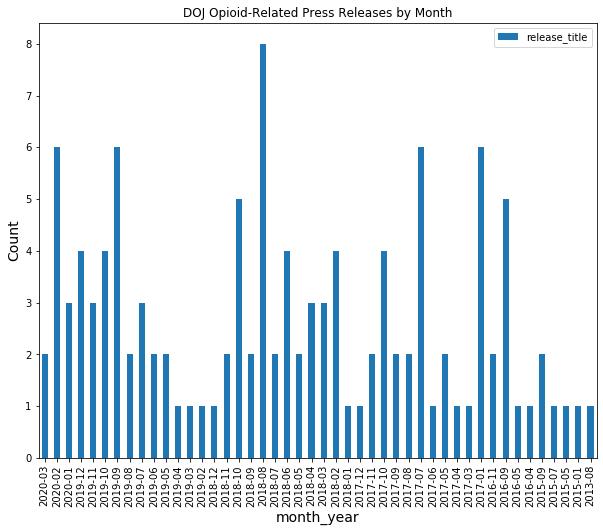

In [51]:
# Chart Opioid Press Releases Found
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title('DOJ Opioid-Related Press Releases by Month')
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
df_pr_count.plot.bar(x ='month_year', ax=ax)

## DATA MINING
* Extract entities and locations for each press release
* Perform NPPES Registry lookup via API call
* Potential Improvement: Look at PhraseMatcher functionality in spaCy to improve NLP results

### Define Functions

In [4]:
# FUNCTION: Extacted entities from cleaned text
def extract_entities(cleaned_text):
    
    # Process cleaned text using spaCy NLP and extract entities labeled as organizations, people, states, cities, countries, and other locations
    df_extracted_entities = pd.DataFrame()

    doc = nlp(cleaned_text)   # run NLP on cleaned text

    # Create empty dataframe for NLP results
    df_extracted_entities = pd.DataFrame(
        columns=[
            'text',
            'start_pos',
            'end_pos',
            'entity_type'
        ]
    )

    # Set list of key entity types to extract
    entity_type_filter = {
        'ORG',          # Companies, agencies, institutions, etc.
        'PERSON',       # People
        'GPE',          # Countries, cities, states
        'LOC'           # Non-GPE locations
    }

    # Parse through NLP results and populate dataframe
    for ent in doc.ents:
    
        if (ent.label_ in entity_type_filter):
    
            df_extracted_entities = df_extracted_entities.append(
                {
                    'text': ent.text,
                    'start_pos': ent.start_char,
                    'end_pos': ent.end_char,
                    'entity_type': ent.label_
                }, 
                ignore_index=True
        )
        
    return df_extracted_entities


In [35]:
# FUNCTION: Parse name into parts in preparation for NPPES API call
def prepare_name_param(df_people):
    
    # Split names into parts
    df_full_name = pd.DataFrame()
    df_full_name = df_people['text'].str.split(" ", n = 4, expand = True)
    #print(df_full_name)
    
    # Rename name-part columns
    for i in range(0, len(df_full_name.columns)):
        col_name = 'name_' + str(i)
        df_full_name = df_full_name.rename(columns={i: col_name})   
    
    #df_full_name
    
    # Determine name-part count for each person
    df_name_part = pd.DataFrame()
    for row in df_full_name.itertuples():
        name_count = 0
    
        for i in range(0, len(df_full_name.columns)):
            if row[i+1] != None:
                name_count += 1
        
        df_name_part = df_name_part.append({'part_count': name_count}, ignore_index=True)

    #df_name_part

    # Combine all name data into single dataframe
    df_combined = pd.DataFrame()
    df_combined = pd.concat([df_people, df_full_name, df_name_part], axis=1)
    #df_combined
    
    # Iterate through people to get first / last name
    df_api_param = pd.DataFrame()
    for row in df_combined.itertuples():
        if row.part_count == 2:
            first_name = row.name_0
            last_name = row.name_1
            make_call = True
        elif row.part_count == 3 or row.part_count == 4:
            first_name = row.name_0
            last_name = row.name_2
            make_call = True
        else:
            make_call = False
        
        if make_call == True:
            df_api_param = df_api_param.append({'first_name': first_name, 'last_name': last_name}, ignore_index=True)
            #print(first_name + '|' + last_name)
    
    print('Number of Identified People: ' + str(len(df_api_param)))
    
    return df_api_param


In [51]:
# FUNCTION: Prepare location for NPPES API call
def prepare_location_param(df_entities):
    # Create dataframe for locations
    df_location = pd.DataFrame()
    df_location = df_entities.loc[df_entities['entity_type'].isin(['GPE', 'LOC'])].reset_index()
    #df_location
    
    if len(df_location) != 0:
    
        # Determine state code for each location
        df_state_code = pd.DataFrame()
        for row in df_location.itertuples():
            state_code = state_code_lookup(row.text)
            df_state_code = df_state_code.append({'state_code': state_code}, ignore_index=True)

    else:
        df_state_code = pd.DataFrame()
        df_state_code = df_state_code.append({'state_code': 'XX'}, ignore_index=True)
        #df_state_code
    
    df_filtered_state = pd.DataFrame()
    df_filtered_state = df_state_code[(df_state_code.state_code != 'XX')].copy()
    df_filtered_state = df_filtered_state.drop_duplicates()
    
    print('Number of Identified, Unique States: ' + str(len(df_filtered_state)))
    
    return df_filtered_state
    

In [7]:
# FUNCTION: Determine state code needed for NPPES API call and return 2 letter code
def state_code_lookup(state_name):
    try:
        state_code = df_state_abbrev.loc[df_state_abbrev['name'] == state_name, 'state'].iloc[0]
    except:
        state_code = 'XX'
     
    return state_code

In [8]:
# FUNCTION: Construct NPPES API call and return string
#     NOTE: All paramaters included (commented out) but only First Name, Last Name, and State used
def construct_nppes_api_call(first_name, last_name, state_code):
    nppes_api = ('https://npiregistry.cms.hhs.gov/api/?'
        #+ 'number='  
        #+ '&enumeration_type='  
        #+ '&taxonomy_description='  
        + '&first_name=' + first_name  
        + '&last_name=' + last_name  
        #+ '&organization_name='  
        #+ '&address_purpose='  
        #+ '&city='   
        + '&state=' + state_code  
        #+ '&postal_code='  
        #+ '&country_code='  
        #+ '&limit='  
        #+ '&skip='  
        #+ '&pretty=on'  
        + '&version=2.1'
    )
    
    return nppes_api

In [9]:
# FUNCTION: Perform NPPES API call and return results as EasyDict object
def call_nppes_api(first_name, last_name, state):
    #state_code = state_code_lookup(state_name)
    nppes_api = construct_nppes_api_call(first_name, last_name, state)
    #print(nppes_api)
    response = requests.get(nppes_api)

    #print('Status Code: ' + str(response.status_code))
    
    #df_api_results = json.loads(response.text)
    api_results = edict(json.loads(response.text))
    
    #print('Length of Dict Result: ' + str(len(api_results)))
    
    return api_results

### Process Press Releases 

In [68]:
# Create dataframe of press release text
df_mining = df_press_releases[['release_title', 'release_text']].copy()
df_mining

,release_title,release_text
0,Owner of Detroit-Area Health Care Clinic Sente...,The owner of a Detroit-area physical therapy c...
1,Tennessee Medical Doctor and Advanced Practice...,A Tennessee medical doctor and an advanced pra...
2,Owner of Detroit-Area Health Care Clinics Plea...,"The owner of a Detroit, Michigan-area physical..."
3,Federal Health Care Fraud Takedown in Northeas...,The Justice Department today announced a coord...
4,Two East Tennessee Doctors Plead Guilty to Opi...,Two Tennessee doctors each pleaded guilty yest...
...,...,...
127,Long-Term Care Pharmacy to Pay $31.5 Million t...,PharMerica Corporation has agreed to pay the U...
128,United States Files Lawsuit Against PharMerica...,The United States has filed suit against PharM...
129,Versailles Man Indicted for Illegal Distributi...,A federal grand jury returned an indictment ch...
130,Colombian National Charged in North Dakota wit...,Acting U.S. Attorney Christopher C. Myers for ...


In [ ]:
for row in df_mining.head(2).itertuples():
    print(row[1])

In [69]:
# LOOP TO GO HERE TO GO THRU ALL PRESS RELEASES AND:
# - clean text
# - extract all entities
# - find people
# ---- determine first and last name
# - find locations
# ---- determine unique states and get associated state code 
# - perform NPPES lookup
# ---- create and execute API call
# ---- retrieve and store results

# Create dataframe to hold NPPES API Results
df_api_results = pd.DataFrame()  

for row in df_mining.itertuples():
    print('TITLE: ' + row[1] + ' for row ' + str(row[0]))
    
    # Clean press release text (remove non-ascii chars, new lines, etc.)
    #cleaned_text = df_mining['release_text'][20].encode('ascii', 'ignore').decode()   # remove non-ASCII characters
    cleaned_text = ''
    cleaned_text = row[2].encode('ascii', 'ignore').decode()   # remove non-ASCII characters
    cleaned_text = cleaned_text.replace('\n', '')              # remove new lines
    cleaned_text = cleaned_text.replace('.,', '. ')            # remove ".," which occurs frequently 
    #print (cleaned_text)

    df_entities = pd.DataFrame()
    df_entities = extract_entities(cleaned_text)   # call function to extract entities from cleaned text
    
    # Create dataframe of identified people
    df_people = pd.DataFrame()
    df_people = df_entities.loc[df_entities['entity_type'] == 'PERSON'].reset_index()
    #df_people
    
    # Create dataframe for name parameters
    df_name_params = pd.DataFrame()
    df_name_params = prepare_name_param(df_people)
    
    # Create dataframe for location parameters
    df_location_params = pd.DataFrame()
    df_location_params = prepare_location_param(df_entities)

    if len(df_name_params) == 0 or len(df_location_params) == 0:
        process = False
    else:
        process = True

    if process == True: 
        for state in df_location_params['state_code']:
            for row in df_name_params.itertuples():
                #nppes_api = construct_nppes_api_call(row.first_name, row.last_name, state)
                api_results = call_nppes_api(row.first_name, row.last_name, state)
                df_api_results = df_api_results.append(pd.DataFrame.from_dict(api_results), ignore_index=True)
    

TITLE: Owner of Detroit-Area Health Care Clinic Sentenced to Prison for a Drug Diversion Scheme for row 0
Number of Identified People: 9
Number of Identified, Unique States: 1
TITLE: Tennessee Medical Doctor and Advanced Practice Registered Nurse Charged in Scheme to Unlawfully Distribute Controlled Substances for row 1
Number of Identified People: 9
Number of Identified, Unique States: 1
TITLE: Owner of Detroit-Area Health Care Clinics Pleads Guilty to Drug Diversion Scheme for row 2
Number of Identified People: 8
Number of Identified, Unique States: 1
TITLE: Federal Health Care Fraud Takedown in Northeastern U.S. Results in Charges Against 48 Individuals  for row 3
Number of Identified People: 84
Number of Identified, Unique States: 8
TITLE: Two East Tennessee Doctors Plead Guilty to Opioid Offenses for row 4
Number of Identified People: 9
Number of Identified, Unique States: 1
TITLE: Former Mexican State Attorney General Sentenced to 20 Years in Prison for Participation in Internati

In [70]:
df_api_results

,result_count,results
0,1,"{'enumeration_type': 'NPI-1', 'number': 117453..."
1,1,"{'enumeration_type': 'NPI-1', 'number': 100316..."
2,1,"{'enumeration_type': 'NPI-1', 'number': 108317..."
3,1,"{'enumeration_type': 'NPI-1', 'number': 100345..."
4,1,"{'enumeration_type': 'NPI-1', 'number': 116483..."
...,...,...
851,7,"{'enumeration_type': 'NPI-1', 'number': 170082..."
852,7,"{'enumeration_type': 'NPI-1', 'number': 151829..."
853,7,"{'enumeration_type': 'NPI-1', 'number': 108391..."
854,7,"{'enumeration_type': 'NPI-1', 'number': 173056..."


In [71]:
# Output file with results of NPPES Lookups for extracted entities
df_api_results.to_csv('nppes_results.csv', index=False)

## FOR DEBUGGING PURPOSES ONLY
### Manual Processing of Press Release Data Mining for debugging isolated issues

In [ ]:
# Clean press release text (remove non-ascii chars, new lines, etc.)
cleaned_text = df_mining['release_text'][74].encode('ascii', 'ignore').decode()   # remove non-ASCII characters
cleaned_text = cleaned_text.replace('\n', '')              # remove new lines
cleaned_text = cleaned_text.replace('.,', '. ')            # remove ".," which occurs frequently 
print (cleaned_text)

In [ ]:
type(cleaned_text)

In [38]:
# Process cleaned text using spaCy NLP and extract entities labeled as organizations, people, states, cities, countries, and other locations
df_extracted_entities = pd.DataFrame()

doc = nlp(cleaned_text)   # run NLP on cleaned text

# Create empty dataframe for NLP results
df_extracted_entities = pd.DataFrame(
    columns=[
        'text',
        'start_pos',
        'end_pos',
        'entity_type'
    ]
)

# Set list of key entity types to extract
entity_type_filter = {
    'ORG',          # Companies, agencies, institutions, etc.
    'PERSON',       # People
    'GPE',          # Countries, cities, states
    'LOC'           # Non-GPE locations
}

# Parse through NLP results and populate dataframe
for ent in doc.ents:
    
    if (ent.label_ in entity_type_filter):
    
        df_extracted_entities = df_extracted_entities.append(
            {
                'text': ent.text,
                'start_pos': ent.start_char,
                'end_pos': ent.end_char,
                'entity_type': ent.label_
            }, 
            ignore_index=True
    )
        
df_extracted_entities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         5 non-null      object
 1   start_pos    5 non-null      object
 2   end_pos      5 non-null      object
 3   entity_type  5 non-null      object
dtypes: object(4)
memory usage: 288.0+ bytes


In [39]:
df_extracted_entities

,text,start_pos,end_pos,entity_type
0,The Department of Justice,0,25,ORG
1,The Justice Department,576,598,ORG
2,Jeff Sessions,867,880,PERSON
3,Trump,1180,1185,PERSON
4,the Department of Justice,1269,1294,ORG


In [40]:
# Create dataframe of identified people
df_people = pd.DataFrame()
df_people = df_extracted_entities.loc[df_extracted_entities['entity_type'] == 'PERSON'].reset_index()
df_people

,index,text,start_pos,end_pos,entity_type
0,2,Jeff Sessions,867,880,PERSON
1,3,Trump,1180,1185,PERSON


In [41]:
# Split names into parts
df_full_name = pd.DataFrame()
df_full_name = df_people['text'].str.split(" ", n = 4, expand = True)
print(df_full_name)

       0         1
0   Jeff  Sessions
1  Trump      None


In [42]:
# Rename name-part columns
for i in range(0, len(df_full_name.columns)):
    col_name = 'name_' + str(i)
    df_full_name = df_full_name.rename(columns={i: col_name})   
    
df_full_name

,name_0,name_1
0,Jeff,Sessions
1,Trump,None


In [43]:
# Determine name-part count for each person
df_name_part = pd.DataFrame()
for row in df_full_name.itertuples():
    name_count = 0
    
    for i in range(0, len(df_full_name.columns)):
        if row[i+1] != None:
            name_count += 1
    
    df_name_part = df_name_part.append({'part_count': name_count}, ignore_index=True)

df_name_part

,part_count
0,2.0
1,1.0


In [44]:
# Combine all name data into single dataframe
df_combined = pd.DataFrame()
df_combined = pd.concat([df_people, df_full_name, df_name_part], axis=1)
df_combined

,index,text,start_pos,end_pos,entity_type,name_0,name_1,part_count
0,2,Jeff Sessions,867,880,PERSON,Jeff,Sessions,2.0
1,3,Trump,1180,1185,PERSON,Trump,None,1.0


In [45]:
# Iterate through people to get first / last name
df_api_param = pd.DataFrame()
for row in df_combined.itertuples():
    if row.part_count == 2:
        first_name = row.name_0
        last_name = row.name_1
        make_call = True
    elif row.part_count == 3 or row.part_count == 4:
        first_name = row.name_0
        last_name = row.name_2
        make_call = True
    else:
        make_call = False
        
    if make_call == True:
        df_api_param = df_api_param.append({'first_name': first_name, 'last_name': last_name}, ignore_index=True)
        #print(first_name + '|' + last_name)
        
df_api_param        

,first_name,last_name
0,Jeff,Sessions


In [21]:
len(df_api_param)

0

In [46]:
# Create dataframe for locations
df_location = pd.DataFrame()
df_location = df_extracted_entities.loc[df_extracted_entities['entity_type'].isin(['GPE', 'LOC'])].reset_index()
df_location

,index,text,start_pos,end_pos,entity_type


In [47]:
# Determine state code for each location
df_state_code = pd.DataFrame()
for row in df_location.itertuples():
    state_code = state_code_lookup(row.text)
    df_state_code = df_state_code.append({'state_code': state_code}, ignore_index=True)

df_state_code

""


In [24]:
df_filtered_state = pd.DataFrame()
df_filtered_state = df_state_code[(df_state_code.state_code != 'XX')].copy()
df_filtered_state = df_filtered_state.drop_duplicates()
df_filtered_state

,state_code


In [25]:
len(df_filtered_state)

0

In [26]:
# Create API call, execute, and store results
df_api_results = pd.DataFrame()

if len(df_api_param) == 0 or len(df_filtered_state) == 0:
    process = False
else:
    process = True

print(process)
    
if process == True:    
    for state in df_filtered_state['state_code']:
        for row in df_api_param.itertuples():
            #nppes_api = construct_nppes_api_call(row.first_name, row.last_name, state)
            api_results = call_nppes_api(row.first_name, row.last_name, state)
                
            df_api_results = df_api_results.append(pd.DataFrame.from_dict(api_results), ignore_index=True)


False


In [ ]:
# Hard-coded test of api call and response
nppes_api = 'https://npiregistry.cms.hhs.gov/api/?number=&enumeration_type=&taxonomy_description=&first_name=Darrel&last_name=Rinehart&organization_name=&address_purpose=&city=&state=MD&postal_code=&country_code=&limit=&skip=&pretty=on&version=2.1'
response = requests.get(nppes_api)
print(response.json())